# Определение стоимости автомобилей

Основная цель: построить модель для определения стоимости б/у автомобилей.  

Вводные: 
* исторические данные
* технические характеристики
* комплектации
* цены автомобилей

Заказчику важны:

- качество предсказания - целевой показатель клиента среднеквадратичная ошибка (RMSE);
- скорость предсказания;
- время обучения.

# Описание данных

Признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя  

Целевой признак

* Price — цена (евро)

# Задачи

* Загрузить,подготовить и исследовать данные.
* Обучить разные модели.
* Проанализировать скорость работы и качество моделей.
* Выбрать наулилучшую модель по 3 параметрам: качество, скорость и время обучения.

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('/Users/andreyshagin/Downloads/autos.csv')

In [3]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Делаю проверку на пропуски, дубликаты, также смотрю общую информацию и корреляцию

In [4]:
def check (dataframe):
    display ('*******'*5)
    dataframe.info()
    display (dataframe.describe(include = 'all'))
    display ('Пропуски',dataframe.isna().sum())
    display ('Сумма дубликатов',dataframe.duplicated().sum())
    plt.figure(figsize=(8,8))
    sns.heatmap(dataframe.corr(),  cmap='RdYlGn', center=0, annot=True)
    plt.show()

'***********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


'Пропуски'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

'Сумма дубликатов'

4

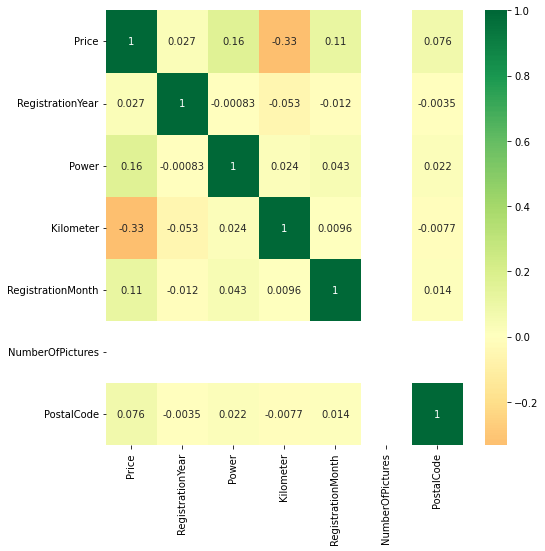

In [5]:
check (df)

После первичного знакомства с нашими данными можно сделать вывод, что:

* В RegistrationYear (регистрация автомобиля) минимальное значение 1000 год, максимальное 9999 год, это ошибка, далее нужно удалить лишние;
* В Power (мощность)минимум 0, а максимум 20000. Мощность в лощадиных силах, поэтому 0 точно ошибка, но и значение 20000 тоже, самые мощные серийные машины до 1000 л.с. за единичным редким исключением;
* В столбце NumberOfPictures не ни одного значения. Можно удалить данный столбец;
* В Price (цена) есть аномальное значение в 0, это ошибка. В даннном столбце будет сложно корректно убрать лишние данные, так как минимальную цену для б/у автомобиля сложно оценить, его могут продавать под востановление.
* В столбце RegistrationMonth есть 0, вероятно это значит отсутствие данных;
* В столбцах: VehicleType, Gearbox, Model, FuelType, NotRepaired есть пропущенные значения;
* В столбце Kilometer 50,75 квантили и максимальное значение 150 000 км, вероятно при заполнении данных есть шаблон - пробег более 150 000 км
* Есть 4 дубликата

Удаляем дубликаты и проверяем

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Проверяем какие значения в годе регистрации

In [9]:
df ['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

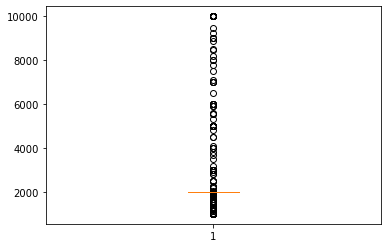

In [10]:
plt.boxplot(df ['RegistrationYear'])
plt.show()

Она из первых машин "Motorwagen" появилась в 1886, но полноценное серийное производтсво начинается после 1900 года, в значениях видно, что нет значений между 1800 и 1910 годами, можно поставить нижнюю отсечку в 1886. 
Верхнюю отсечку ставлю 2016 год включительно, это последний год выгрузки.

In [11]:
df1 = df.loc[(df['RegistrationYear'] >= 1886) & (df['RegistrationYear'] <= 2016)]

In [12]:
df1 ['RegistrationYear'].sort_values().unique()

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016])

Мощность в данных идет от 0 до 20000

In [13]:
df ['Power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

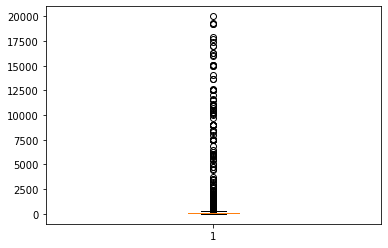

In [14]:
plt.boxplot(df ['Power'])
plt.show()

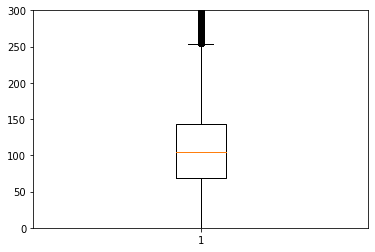

In [15]:
plt.boxplot(df ['Power'])
plt.ylim(0, 300)
plt.show()

Основные значения в диапазоне примерно от 75 до 125.  
Просмотрев популярный сайт Автоскаут я увидел, что действительно много предложений с нереалистичными значениями в районе от 1 до 50 л.с., поэтому эти данные будет опасно обрезать, нижнюю границу задаю от 1 включительно.  
Верхнюю границу ставлю в 1000 л.с., для серийный машин это практически максимум, и то это единичные случаи, но и они должны быть в модели для оценки.

In [16]:
df1 = df1.loc[(df1['Power'] >= 1) & (df1['Power'] <= 1000)]

С ценой схожая ситуация, как с мощностью, на сайтах действительно есть предложения по 1 евро, это проблемные машины, но нет продажи за 0 евро, поэтому убираю значения с ценой 0 евро.

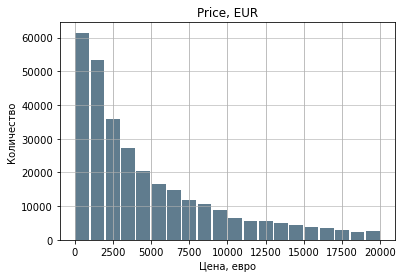

In [17]:
df1 ['Price'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Price, EUR')
plt.xlabel('Цена, евро')
plt.ylabel('Количество')
plt.grid(axis='y', alpha=0.75)

Проверяю, какие значения лежат в диапазоне от 1 до 50, тут разные модели и новые и старые, ремонтированные и нет, однозначно сказать что это ошибка нельзя, поэтому оставляем.

In [18]:
df1 [(df1['Price']<50) & (df1['Price']>1)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1025,2016-03-15 18:57:12,3,convertible,1998,manual,110,mx_reihe,150000,11,NaN,mazda,yes,2016-03-15 00:00:00,0,89312,2016-04-06 21:16:58
1634,2016-03-13 03:36:19,2,bus,2004,manual,135,scenic,150000,0,petrol,renault,NaN,2016-03-13 00:00:00,0,30926,2016-04-02 15:17:36
3071,2016-03-24 19:57:53,30,sedan,1995,manual,75,polo,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,59067,2016-04-05 13:16:29
3742,2016-03-23 17:30:02,2,sedan,2002,auto,272,7er,5000,9,petrol,bmw,NaN,2016-03-23 00:00:00,0,65183,2016-03-24 21:28:34
6669,2016-03-23 12:40:54,9,small,1994,manual,90,golf,150000,9,petrol,volkswagen,no,2016-03-23 00:00:00,0,3054,2016-04-05 11:18:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342742,2016-03-13 02:57:07,3,sedan,2007,manual,65,clio,125000,3,petrol,renault,no,2016-03-13 00:00:00,0,41334,2016-03-15 15:15:16
343524,2016-04-05 09:36:24,10,NaN,2000,NaN,170,vectra,150000,12,NaN,opel,NaN,2016-04-05 00:00:00,0,93449,2016-04-07 13:17:27
349043,2016-03-26 11:39:00,10,small,1999,NaN,75,NaN,150000,0,NaN,volkswagen,no,2016-03-26 00:00:00,0,85221,2016-04-05 22:45:11
351442,2016-03-11 08:55:34,20,NaN,1970,NaN,55,NaN,150000,8,NaN,opel,NaN,2016-03-11 00:00:00,0,59872,2016-04-06 11:45:55


Поэтому чтобы не обрезать полезную информацию убираю только нулевые значения

In [19]:
df1 = df1.loc[df1['Price'] >= 1]

In [20]:
df1.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,296633.000000,296633.000000,296633.000000,296633.000000,296633.000000,296633.0,296633.000000
mean,4854.625099,2002.815206,120.727377,128260.443039,5.992890,0.0,51237.013188
std,4612.152399,6.558912,54.852889,36808.502616,3.584171,0.0,25782.950105
min,1.000000,1910.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30926.000000
50%,3200.000000,2003.000000,111.000000,150000.000000,6.000000,0.0,50259.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72108.000000
max,20000.000000,2016.000000,1000.000000,150000.000000,12.000000,0.0,99998.000000


Работа с пропусками

In [21]:
df1.isnull().sum().sort_values(ascending = False)

NotRepaired          42980
FuelType             15594
Model                11209
VehicleType          11057
Gearbox               5391
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [22]:
def func (dataframe):
    display (dataframe.value_counts(normalize=True))

В значения по ремонту только да и нет, пропуски вероятно значат нет информации, ставим вместо пропусков.

In [23]:
func(df1['NotRepaired'])

no     0.885848
yes    0.114152
Name: NotRepaired, dtype: float64

In [24]:
df1['NotRepaired'] = df1['NotRepaired'].fillna('no info')

В значения по типу топлива есть значение другое, значит все пропуски это отсутвие информации, также меняю на нет информации.

In [25]:
func(df1['FuelType'])

petrol      0.667648
gasoline    0.312636
lpg         0.016677
cng         0.001719
hybrid      0.000719
other       0.000331
electric    0.000270
Name: FuelType, dtype: float64

In [26]:
df1['FuelType'] = df1['FuelType'].fillna('no info')

В значения по типу машины есть значение другое, значит все пропуски это отсутвие информации, также меняю на нет информации, аналогично типу машины.

In [27]:
func(df1['VehicleType'])

sedan          0.290984
small          0.245567
wagon          0.207573
bus            0.091804
convertible    0.065741
coupe          0.051202
suv            0.038389
other          0.008740
Name: VehicleType, dtype: float64

In [28]:
df1['VehicleType'] = df1['VehicleType'].fillna('no info')

В значения модель конкретные наименования, значит пропуски это отсутствие информации, меняю на нет информации.

In [29]:
func(df1['Model'])

golf                  0.086643
other                 0.071700
3er                   0.060920
polo                  0.037474
corsa                 0.035509
                        ...   
serie_2               0.000018
kalina                0.000018
serie_3               0.000011
range_rover_evoque    0.000007
rangerover            0.000007
Name: Model, Length: 249, dtype: float64

In [30]:
df1['Model'] = df1['Model'].fillna('no info')

В типе коробки передач, можно предположить, что есть еще и вариантор, но наверно он часть автоматической коробки передач, также меняю на нет информации.

In [31]:
func(df1['Gearbox'])

manual    0.797581
auto      0.202419
Name: Gearbox, dtype: float64

In [32]:
df1['Gearbox'] = df1['Gearbox'].fillna('no info')

Проверяем, что пропусков не осталось

In [33]:
df1.isnull().sum().sort_values(ascending = False)

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

## Обучение моделей

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296633 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        296633 non-null  object
 1   Price              296633 non-null  int64 
 2   VehicleType        296633 non-null  object
 3   RegistrationYear   296633 non-null  int64 
 4   Gearbox            296633 non-null  object
 5   Power              296633 non-null  int64 
 6   Model              296633 non-null  object
 7   Kilometer          296633 non-null  int64 
 8   RegistrationMonth  296633 non-null  int64 
 9   FuelType           296633 non-null  object
 10  Brand              296633 non-null  object
 11  NotRepaired        296633 non-null  object
 12  DateCreated        296633 non-null  object
 13  NumberOfPictures   296633 non-null  int64 
 14  PostalCode         296633 non-null  int64 
 15  LastSeen           296633 non-null  object
dtypes: int64(7), object(

Удаляем не нужные столбцы: 
* DateCrawled - дата скачивания анкеты - не влияет на цену
* NumberOfPictures - был бы нужен, но в нем нет информации
* PostalCode - почтовый индекс владельца, не влияет. Если был бы регион продажи это бы влияло
* LastSeen - дата последнего присутствия на сайте не нужна
* DateCreated - не имеет значимого влияния на цену
* RegistrationMonth - не влияет на цену, покупатели ориентируются на год выпуска

In [35]:
df1 = df1.drop (['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated', 'RegistrationMonth'],axis = 1)


Меняем тип данных object на category

In [36]:
for col in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']:
    df1[col] = df1[col].astype('category')

Датафрейм с кодированными категориальными признаками делю на target и features

In [37]:
target = df1['Price']
features = df1.drop('Price', axis=1)

Делю на выборки в пропорции 60/20/20 тренировочная/валидационная/тестовая

In [38]:
features_train, x_valid, target_train, y_valid = train_test_split(
   features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    x_valid,y_valid, test_size=0.5, random_state=12345)

In [39]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177979 entries, 326694 to 259860
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       177979 non-null  category
 1   RegistrationYear  177979 non-null  int64   
 2   Gearbox           177979 non-null  category
 3   Power             177979 non-null  int64   
 4   Model             177979 non-null  category
 5   Kilometer         177979 non-null  int64   
 6   FuelType          177979 non-null  category
 7   Brand             177979 non-null  category
 8   NotRepaired       177979 non-null  category
dtypes: category(6), int64(3)
memory usage: 6.6 MB


Выполняю кодирование категориальных переменных методом OrdinalEncoder

In [40]:
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model', 'Gearbox','NotRepaired']
#train
cat_features_train = features_train[cat_columns]
cat_features_train = pd.DataFrame(encoder.fit_transform(cat_features_train),
                                columns=cat_features_train.columns, 
                                index=cat_features_train.index)
features_train_OE = features_train.copy()
for column in cat_columns:
    features_train_OE[column] = cat_features_train[column]
#test
cat_features_test = features_test[cat_columns]
cat_features_test = pd.DataFrame(encoder.fit_transform(cat_features_test),
                                columns=cat_features_test.columns, 
                                index=cat_features_test.index)
features_test_OE = features_test.copy()
for column in cat_columns:
    features_test_OE[column] = cat_features_test[column]
#valid
cat_features_valid = features_valid[cat_columns]
cat_features_valid = pd.DataFrame(encoder.fit_transform(cat_features_valid),
                                columns=cat_features_valid.columns, 
                                index=cat_features_valid.index)
features_valid_OE = features_valid.copy()
for column in cat_columns:
    features_valid_OE[column] = cat_features_valid[column]

In [41]:
features_train_OE

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
326694,6.0,2001,1.0,80,177.0,150000,7.0,9.0,2.0
262927,6.0,2010,1.0,84,45.0,150000,4.0,3.0,2.0
178861,8.0,2000,0.0,136,59.0,150000,4.0,20.0,0.0
51125,8.0,1997,1.0,136,165.0,150000,7.0,24.0,1.0
318799,6.0,2004,1.0,37,143.0,150000,7.0,38.0,2.0
...,...,...,...,...,...,...,...,...,...
189718,8.0,1999,1.0,136,161.0,150000,5.0,2.0,2.0
57321,5.0,1998,1.0,75,42.0,150000,7.0,24.0,0.0
103194,5.0,2005,1.0,105,28.0,150000,2.0,1.0,1.0
92371,8.0,1998,1.0,101,164.0,150000,7.0,31.0,1.0


Выполняю кодирование категориальных переменных методом OHE для линейной модели

In [42]:
features_train_ohe = pd.get_dummies(features_train, drop_first = True)
features_test_ohe = pd.get_dummies(features_test, drop_first = True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first = True)

In [43]:
print(f'Размер обучающей выборки составляет: {features_train.shape[0] / df1.shape[0]:.1%}')
print(f'Размер валидационной выборки составляет: {features_valid.shape[0] / df1.shape[0]:.1%}')
print(f'Размер тестовой выборки составляет: {features_test.shape[0] / df1.shape[0]:.1%}')

Размер обучающей выборки составляет: 60.0%
Размер валидационной выборки составляет: 20.0%
Размер тестовой выборки составляет: 20.0%


Масштабирую числовые переменные

In [45]:
pd.options.mode.chained_assignment = None
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Линейная регрессия

In [46]:
LRmodel = LinearRegression()

Обучаем модель.

In [47]:
tic_LRfit = time.time()
LRmodel.fit(features_train_ohe, target_train)
toc_LRfit = time.time()
time_taken_LRfit = toc_LRfit - tic_LRfit 

Затраченное время на обучение в секундах

In [48]:
time_taken_LRfit

2.5316410064697266

In [49]:
tic_LRpred = time.time()

predictions_valid_LR = LRmodel.predict(features_valid_ohe)
RMSE_LR = mean_squared_error(target_valid, predictions_valid_LR)**0.5
RMSE_LR
toc_LRpred = time.time()
time_taken_LRpred = toc_LRpred - tic_LRpred 

In [50]:
RMSE_LR

2615.3968895126113

Время затраченное на предсказание в секундах

In [51]:
time_taken_LRpred

0.25432491302490234

У модели долгое время обучения и предсказания. Параметр RMSE сравним с дальнейшими моделями.

### Случайный лес

In [52]:
RFmodel = RandomForestRegressor(random_state=42, n_estimators=15, max_depth = 20)

Обучаем модель.

In [53]:
tic_RFmodel = time.time()
RFmodel.fit(features_train_ohe, target_train)
toc_RFmodel = time.time()
time_taken_RFmodel = toc_LRfit - tic_LRfit 

In [54]:
time_taken_RFmodel

2.5316410064697266

In [55]:
tic_RFmodel_pred = time.time()
predictions_valid_RF = RFmodel.predict(features_valid_ohe)
RMSE_RF = mean_squared_error(target_valid, predictions_valid_RF)**0.5
toc_RFmodel_pred = time.time()
time_taken_RFmodel_pred = toc_RFmodel_pred - tic_RFmodel_pred 

In [56]:
time_taken_RFmodel_pred

0.4118659496307373

Среднеквадратичная ошибка (RMSE) значительно ниже, чем у линейной регрессии. Подбираю параметры, чтобы улучшить результат

In [57]:
RMSE_RF

1631.0648964234088

In [58]:
regressor = RandomForestRegressor() 
max_depth_list = [x for x in range(20,36,5)]
n_estimators_list = [x for x in range(15, 26,5)]
hyperparams = [{'criterion':['squared_error'], 
                'n_estimators': [15],
                'max_depth':n_estimators_list, 
                'random_state':[42]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train)
print(clf.best_params_)

{'criterion': 'squared_error', 'max_depth': 25, 'n_estimators': 15, 'random_state': 42}


In [59]:
RFmodel1 = RandomForestRegressor(criterion='squared_error', 
                              max_depth=21,
                                 n_estimators = 15,
                              random_state=19072020)

In [60]:
tic_RFmodel1 = time.time()
RFmodel1.fit(features_train_ohe, target_train)
toc_RFmodel1 = time.time()
time_taken_RFmodel1 = toc_RFmodel1 - tic_RFmodel1

In [61]:
time_taken_RFmodel1

38.45230507850647

In [62]:
tic_RFmodel1_pred = time.time()
predictions_valid_RF1 = RFmodel1.predict(features_valid_ohe)
RMSE_RF1 = mean_squared_error(target_valid, predictions_valid_RF1)**0.5
toc_RFmodel1_pred = time.time()
time_taken_RFmodel1_pred = toc_RFmodel1_pred - tic_RFmodel1_pred 

In [63]:
time_taken_RFmodel1_pred

0.41347384452819824

Среднеквадратичная ошибка стала еще ниже

In [64]:
RMSE_RF1

1622.9710895196968

### LGBM регрессия

Обучаем модель.

In [65]:
tic_LGBMmodel_fit = time.time()

LGBM_model = LGBMRegressor(random_state=42)
LGBM_model.fit(features_train, target_train)
toc_LGBMmodel_fit = time.time()
time_taken_LGBMmodel_fit = toc_LGBMmodel_fit - tic_LGBMmodel_fit 

In [66]:
time_taken_LGBMmodel_fit

0.4532201290130615

In [67]:
tic_LGBMmodel_pred = time.time()

predictions_valid_LGBM = LGBM_model.predict(features_valid)
RMSE_LGBN = mean_squared_error(target_valid, predictions_valid_LGBM)**0.5

toc_LGBMmodel_pred = time.time()
time_taken_LGBMmodel_pred = toc_LGBMmodel_pred - tic_LGBMmodel_pred 

In [68]:
RMSE_LGBN

1619.4911348402961

In [69]:
time_taken_LGBMmodel_pred

0.09665703773498535

Подбираю гиперпараметры для улучшения результата

In [70]:
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[50, 100, 300], 
                'learning_rate':[0.05, 0.1, 0.3],
                'max_depth': [-1, 100,600],
                'random_state':[42]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)

{'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 300, 'random_state': 42}


In [71]:
LGBM_model1 = LGBMRegressor(learning_rate=0.1,
                            max_depth=-1,
                      num_leaves=300, 
                      random_state=19072020)

In [72]:
tic_LGBMmodel1_fit = time.time()
LGBM_model1.fit(features_train, target_train)
toc_LGBMmodel1_fit = time.time()
time_taken_LGBMmodel1_fit = toc_LGBMmodel1_fit - tic_LGBMmodel1_fit

In [73]:
time_taken_LGBMmodel1_fit

1.9055991172790527

In [74]:
tic_LGBMmodel1_pred = time.time()
predictions_valid_LGBM1 = LGBM_model1.predict(features_valid)
RMSE_LGBN1 = mean_squared_error(target_valid, predictions_valid_LGBM1)**0.5
toc_LGBMmodel1_pred = time.time()
time_taken_LGBMmodel1_pred = toc_LGBMmodel1_pred - tic_LGBMmodel1_pred 

In [75]:
time_taken_LGBMmodel1_pred

0.22090792655944824

In [76]:
RMSE_LGBN1

1528.0833517195313

Параметр RMSE значимо лучше, чем у предыдущих моделей

### Catboost 

Обучаем модель.

In [77]:
tic_CBMmodel_fit = time.time()
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

catboost_model = CatBoostRegressor(random_state=42,silent=True)
catboost_model.fit(features_train, target_train, cat_features=cat_features)
toc_CBmodel_fit = time.time()
time_taken_CBmodel_fit = toc_CBmodel_fit - tic_CBMmodel_fit 

In [78]:
time_taken_CBmodel_fit

58.845365047454834

In [79]:
tic_CBmodel_pred = time.time()

predictions_valid_cat = catboost_model.predict(features_valid)
RMSE_CB = mean_squared_error(target_valid, predictions_valid_cat)**0.5

toc_CBmodel_pred = time.time()
time_taken_CBmodel_pred = toc_CBmodel_pred - tic_CBmodel_pred 

In [80]:
RMSE_CB

1597.1711627215734

In [81]:
time_taken_CBmodel_pred

0.1651320457458496

Пробую улучшить модель, чтобы среднеквадратичная ошибка (RMSE) стала еще меньше

In [82]:
train_data = Pool(data=features_train,
              label=target_train,
              cat_features = cat_features
              )

test_data = Pool(data=features_valid,
              label=target_valid,
              cat_features = cat_features
              )

model_params = {'random_state': 42,
                'eval_metric': 'RMSE',
                'verbose': 100,
                'cat_features': cat_features,
                'loss_function': 'RMSE',
                'learning_rate': 0.3}

cv_params = {'params': model_params,
             'pool': train_data,
             'fold_count': 3,
             'shuffle':True,
             'partition_random_seed':42,
             'verbose': 100,
             'early_stopping_rounds':200}

cv_data = cv(**cv_params)

Training on fold [0/3]
0:	learn: 5094.1470318	test: 5031.7576378	best: 5031.7576378 (0)	total: 99.1ms	remaining: 1m 38s
100:	learn: 1641.2669097	test: 1665.0912470	best: 1665.0912470 (100)	total: 5.14s	remaining: 45.7s
200:	learn: 1570.8816225	test: 1626.7428600	best: 1626.7428600 (200)	total: 10.5s	remaining: 41.8s
300:	learn: 1528.4719081	test: 1607.9916730	best: 1607.9916730 (300)	total: 15.1s	remaining: 35.2s
400:	learn: 1497.8226114	test: 1596.5653556	best: 1596.5291141 (394)	total: 19.5s	remaining: 29.1s
500:	learn: 1472.0344347	test: 1590.9583285	best: 1590.8374093 (498)	total: 24.7s	remaining: 24.6s
600:	learn: 1450.8284487	test: 1585.0822660	best: 1584.9710763 (585)	total: 29.8s	remaining: 19.8s
700:	learn: 1431.0128585	test: 1580.7395938	best: 1580.6670639 (697)	total: 34.7s	remaining: 14.8s
800:	learn: 1412.6011245	test: 1578.1581732	best: 1578.1581732 (800)	total: 39.9s	remaining: 9.91s
900:	learn: 1398.1176353	test: 1576.8489249	best: 1576.8209457 (864)	total: 44.7s	remain

In [83]:
catboost_model1 = CatBoostRegressor(**model_params)

In [84]:
tic_CBMmodel_fit1 = time.time()
catboost_model1.fit(features_train, target_train)
toc_CBmodel_fit1 = time.time()
time_taken_CBmodel_fit1 = toc_CBmodel_fit1 - tic_CBMmodel_fit1

0:	learn: 3740.7143902	total: 75.4ms	remaining: 1m 15s
100:	learn: 1630.3115581	total: 6.01s	remaining: 53.5s
200:	learn: 1566.8567320	total: 12.2s	remaining: 48.4s
300:	learn: 1527.5596994	total: 19.5s	remaining: 45.2s
400:	learn: 1501.3280989	total: 26.5s	remaining: 39.5s
500:	learn: 1479.0032733	total: 32.8s	remaining: 32.7s
600:	learn: 1459.7420719	total: 39.3s	remaining: 26.1s
700:	learn: 1443.3022516	total: 45.4s	remaining: 19.4s
800:	learn: 1430.4973109	total: 51.4s	remaining: 12.8s
900:	learn: 1418.9721742	total: 57.7s	remaining: 6.34s
999:	learn: 1408.6075253	total: 1m 3s	remaining: 0us


In [85]:
tic_CBmodel_pred1 = time.time()
predictions_valid_cat1 = catboost_model1.predict(features_valid)
RMSE_CB1 = mean_squared_error(target_valid, predictions_valid_cat1)**0.5
toc_CBmodel_pred1 = time.time()
time_taken_CBmodel_pred1 = toc_CBmodel_pred1 - tic_CBmodel_pred1

Среднеквадратичная ошибка (RMSE) еще уменьшилась, можно делать сводную таблицу со всеми моделями

In [86]:
RMSE_CB1

1569.8059235424394

In [87]:
time_taken_CBmodel_pred1

0.2590599060058594

In [88]:
model_1 = {'Время обучения, сек': time_taken_LGBMmodel_fit,
            'Время предсказания, сек': time_taken_LGBMmodel_pred,
            'RMSE': RMSE_LGBN}
model_2 = {'Время обучения, сек': time_taken_LGBMmodel1_fit,
            'Время предсказания, сек': time_taken_LGBMmodel_pred,
            'RMSE': RMSE_LGBN1}
model_3 = {'Время обучения, сек': time_taken_LRfit,
            'Время предсказания, сек': time_taken_LRpred,
              'RMSE': RMSE_LR}
model_4 = {'Время обучения, сек': time_taken_RFmodel,
            'Время предсказания, сек': time_taken_RFmodel_pred,
              'RMSE': RMSE_RF}
model_5 = {'Время обучения, сек': time_taken_RFmodel1,
            'Время предсказания, сек': time_taken_RFmodel1_pred,
              'RMSE': RMSE_RF1}
model_6 = {'Время обучения, сек': time_taken_CBmodel_fit,
            'Время предсказания, сек': time_taken_CBmodel_pred,
              'RMSE': RMSE_CB}
model_7 = {'Время обучения, сек': time_taken_CBmodel_fit1,
            'Время предсказания, сек': time_taken_CBmodel_pred1,
              'RMSE': RMSE_CB1}

In [89]:
Models = pd.DataFrame([model_1, model_2, model_3, model_4, model_5, model_6, model_7], 
                      index=['LightGBM', 'LightGBM_tune','LinearRegression', 'RandomForest','RandomForest_tune', 'CatBoost','CatBoost_cv'])

## Анализ моделей

In [90]:
Models

,"Время обучения, сек","Время предсказания, сек",RMSE
LightGBM,0.453220,0.096657,1619.491135
LightGBM_tune,1.905599,0.096657,1528.083352
LinearRegression,2.531641,0.254325,2615.396890
RandomForest,2.531641,0.411866,1631.064896
RandomForest_tune,38.452305,0.413474,1622.971090
CatBoost,58.845365,0.165132,1597.171163
CatBoost_cv,64.517677,0.259060,1569.805924


На основе параметре RMSE лидер LightGBM с подобранными гиперпараметрами, не сильно ей уступает модель CatBoost с кросс-валидацией. По времени обучения и предсказания LGBM значительно быстрее CatBoost.

Проверяю две лучшие модели на тестовой выборке. Результат у модели LGBM снова лучше, RMSE ниже. Показатели на тестовой выборке незначительно хуже.

In [91]:
predictions_test_CB = catboost_model1.predict(features_test)
RMSE = mean_squared_error(target_test, predictions_test_CB)**0.5
RMSE

1573.1662523602163

In [92]:
predictions_test_LGBM = LGBM_model1.predict(features_test)
RMSE1 = mean_squared_error(target_test, predictions_test_LGBM)**0.5
RMSE1

1525.6897398794208

## Вывод

Были выполнены шаги:

Загружены данные, выполнена предобработка (удалены дубликаты, замены пропуски).
Проведено обучение и предсказание моделей с параметрами по умолчанию и дополнительно с использованием различных наборов гиперпараметров.
Выбрана лучшая модель по результатам метрики RMSE и времени обучения.

Лучшая модель по скорости обучения, предсказания - LGBM.

Исходя из этого общая рекомендация:

В качестве использования модели для предсказания цен на б/у автомобили рекомендуется выбрать LGBM с подобранными гиперпараметрами.